# Aula 15 - Laboratório 6 - Análise do sinal de voz com filtro LPC

## Adinan Alves de Brito Filho

In [10]:
import scipy.signal as signal
import numpy as np
import scipy
import matplotlib.pyplot as plt
import librosa
import math
from pylab import *
from IPython.display import Audio
from librosa.display import specshow

In [11]:
 #Plot frequency and phase response - adaptado de http://mpastell.com/pweave/_downloads/FIR_design_rst.html
def mfreqz(b,a=1,fs=44100):
    w,h = signal.freqz(b,a)
    h_dB = 20 * np.log10 (abs(h))
    plot(w/max(w)*fs/2,h_dB)
    ylabel('Amplitude')
    xlabel(r'Frequency [Hz]')
    title(r'Frequency response')
    plt.grid(True)


In [12]:
# Levinson Durbin algorithm from https://github.com/sdual/levinson-durbin
class LevinsonDurbinRecursion:
    """
    --------|---------------------
    R_k     | toeplitz_elements[k]
    --------|---------------------
    E_k     | extra_element
    --------|---------------------
    A_k     | solutions[k]
    --------|---------------------
    U_k     | extended_solution[k]
    --------|---------------------------
    V_k     | r_extended_solution[k]
    Reference: http://www.emptyloop.com/technotes/A%20tutorial%20on%20linear%20prediction%20and%20Levinson-Durbin.pdf
    """

    def __init__(self, toeplitz_elements):
        self.toeplitz_elements = toeplitz_elements
        self.lpc_dim = len(toeplitz_elements) - 2

    def solve(self):
        solutions, extra_ele = self.solve_size_one()
        final_solutions, _ = self.solve_recursively(solutions, extra_ele)
        return final_solutions

    def solve_size_one(self):
        solutions = np.array([1.0, - self.toeplitz_elements[1] / self.toeplitz_elements[0]])
        extra_element = self.toeplitz_elements[0] + self.toeplitz_elements[1] * solutions[1]
        return solutions, extra_element

    def solve_recursively(self, initial_solutions, initial_extra_ele):
        extra_element = initial_extra_ele
        solutions = initial_solutions
        for k in range(1, self.lpc_dim):
            lambda_value = self._calculate_lambda(k, solutions, extra_element)
            extended_solution = self._extend_solution(solutions)
            r_extended_solution = extended_solution[::-1]

            solutions = extended_solution + lambda_value * r_extended_solution
            extra_element = self._calculate_extra_element(extra_element, lambda_value)
        return solutions, extra_element

    def _extend_solution(self, previous_solution):
        return np.hstack((previous_solution, np.array([0.0])))

    def _calculate_extra_element(self, previous_extra_ele, lambda_value):
        return (1.0 - lambda_value**2) * previous_extra_ele

    def _calculate_lambda(self, k, solutions, extra_element):
        tmp_value = 0.0
        for j in range(0, k + 1):
            tmp_value += (- solutions[j] * self.toeplitz_elements[k + 1 - j])
        return tmp_value / extra_element

# Atividades a serem realizadas:
1. Com o seu sinal de voz, gravado na aula 13, identifique pelo menos um frame contendo um sinal de voz do tipo vozeado e um frame contendo um sinal de voz do tipo não vozeado; Plote as formas de ondas destes sinais e os seus espectros de amplitude (como foi feito na Parte 4).

2. Qual a diferença entre as formas de onda obtidas para o sinal de voz vozeado e o sinal de voz não vozeado? E qual a diferença nos espectros de amplitude?

3. Utilizando o trecho do sinal de voz do tipo vozeado, obtenha o espectro de frequência do sinal vozeado e resposta em frequência do filtro obtido com a inversão do filtro LPC, para P = 4, P = 16, P = 32 e P = 64. O que acontece com a resposta em frequência deste filtro?

4. Qual a diferença entre o sinal na entrada do LPC e na sua saída?

5. O que acontece com o sinal de saída do LPC (erro de predição) ao aumentarmos o valor de P?

**As atividades podem ser desenvolvidas utilizando uma cópia deste COLAB e deverá ser compartilhado com o Prof. e o link enviado pelo formulário (link da pasta, contendo o colab e o áudio gravado).**

## Exercício 1
Com o seu sinal de voz, gravado na aula 13, identifique pelo menos um frame contendo um sinal de voz do tipo vozeado e um frame contendo um sinal de voz do tipo não vozeado; Plote as formas de ondas destes sinais e os seus espectros de amplitude (como foi feito na Parte 4).

### Parte 1: Importando e reamostrando o sinal de áudio

In [4]:
audio_sample, sr = librosa.load('Adinan_SM57_HighPass.wav', sr=48000) # 48000 corresponde à taxa de amostragem do sinal

In [5]:
audio_resample = librosa.resample(audio_sample, sr, 8000)
fs = 8000

/var/folders/vt/jqntsjwx37nc28fmphnl32sc0000gn/T/ipykernel_5215/230516453.py:1: FutureWarning: Pass orig_sr=48000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_resample = librosa.resample(audio_sample, sr, 8000)


In [6]:
Audio(data=audio_resample, rate=fs) # Reproduzindo o sinal de voz reamostrado

In [7]:
T = len(audio_resample) # Obtendo o número de amostras do sinal de voz
print(T)

68066


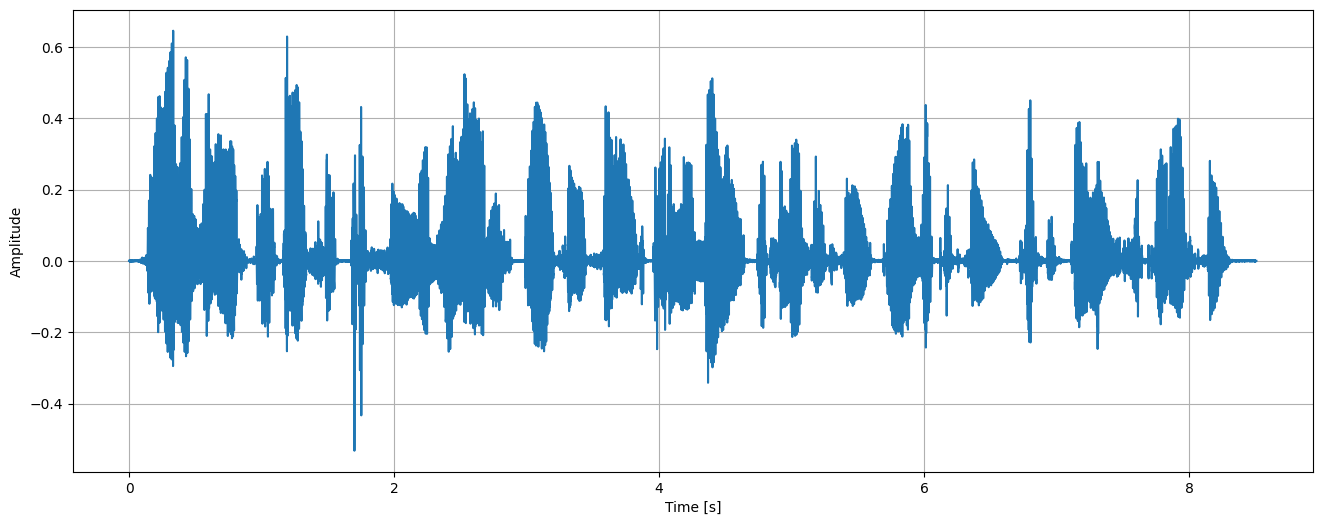

In [13]:
# Plotando o sinal de voz em função do tempo
t  = np.linspace(0,T/fs,T, endpoint=False)
n  = np.linspace(0,T,T, endpoint=False)
plt.figure(figsize=(16,6))
plot(t,audio_resample)
ylabel('Amplitude')
xlabel('Time [s]')
plt.grid(True)

[]

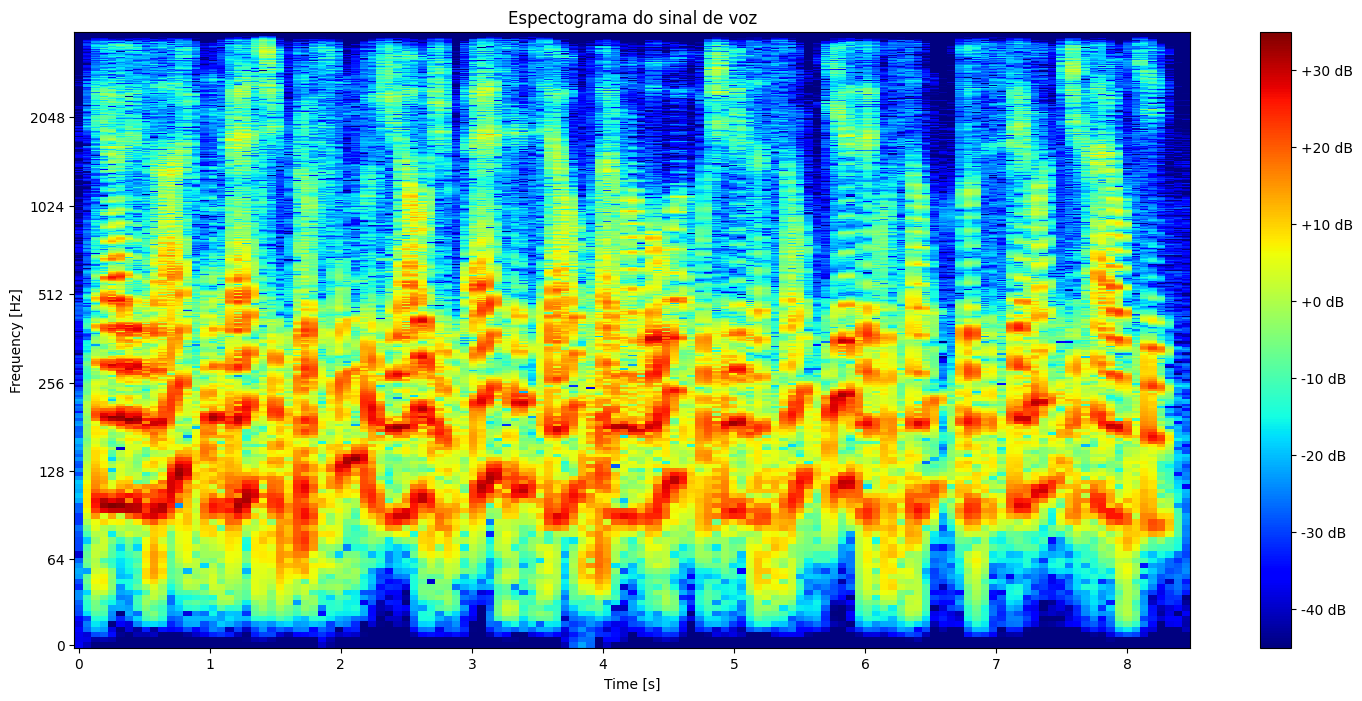

In [14]:
# Obtendo o espectograma do sinal de voz
audio_stft_s = np.abs(librosa.stft(audio_resample))

plt.figure(figsize=(18,8))
specshow(librosa.amplitude_to_db(audio_stft_s), 
         y_axis='log', 
         x_axis='time',
         cmap='jet', 
         sr=fs)
plt.title('Espectograma do sinal de voz')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(format='%+2.0f dB')
plt.plot()

### Parte 2: Janelando o sinal de voz com uma janela de tamanho igual a 25ms (200 amostras a uma taxa de amostragem igual a 8kHz) e uma sobreposição de 50%

In [ ]:
y              = audio_resample
frame_size     = int(0.025*fs) # Tamanho do frame
voice_size     = len(audio_resample)
n_windows      = int(2*voice_size/frame_size-1)
y_window       = np.zeros([n_windows,frame_size])
max_amp_frames = np.zeros([n_windows])
energy_frames  = np.zeros([n_windows])
window         = np.hanning(frame_size)

In [ ]:
for ii in range(n_windows):
      y_window[ii,:]     = y[ii*int(frame_size/2):frame_size+ii*int(frame_size/2)]*window # Janelando o sinal
      max_amp_frames[ii] = max(abs(y_window[ii,:])) # obtendo o valor da maior amplitude absoluta por frame
      energy_frames[ii]  = sum(y_window[ii,:]**2) # calculando a energia do frame

In [ ]:
print(min(max_amp_frames),max(max_amp_frames))
print(min(energy_frames),max(energy_frames))

0.001095034055555878 0.5840986809157048
1.548317060993434e-05 3.5616308206278906


### Parte 3: Obtendo um VAD (Voice Activity Detector) baseado em amplitude

In [ ]:
audio_vad  = np.zeros([n_windows,frame_size])
frames_vad = np.zeros([n_windows,frame_size])
audio_aux  = np.zeros([n_windows])
max_lim    = 0.03 # Limiar de amplitude
kk         = 0
# VAD baseado em amplitude absoluta
for ii in range(n_windows):
    if max_amp_frames[ii] > max_lim:
      audio_vad[ii,:]  = y_window[ii,:]
      frames_vad[ii,:] = np.ones([frame_size])
      audio_aux[ii]    = 1
      kk = kk+1
    else:
      audio_vad[ii,:]  = np.zeros([frame_size])

In [ ]:
z        = np.zeros([voice_size])
for ii in range(n_windows):
      z[ii*int(frame_size/2):frame_size+ii*int(frame_size/2)] = z[ii*int(frame_size/2):frame_size+ii*int(frame_size/2)] + audio_vad[ii,:]

In [ ]:
print(n_windows)

679


(0.0, 679.0)

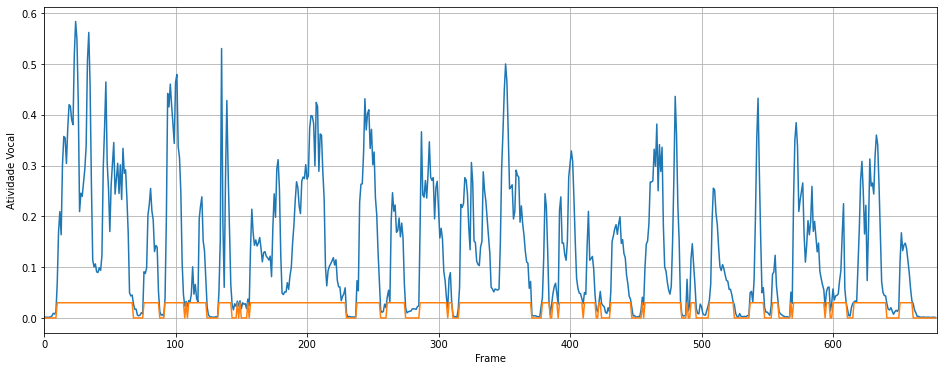

In [ ]:
plt.figure(figsize=(16,6))

ii_ini = 0
ii_end = 679

plot(max_amp_frames)
plt.grid(True)

plot(audio_aux*max_lim)
ylabel('Atividade Vocal')
xlabel('Frame')
plt.grid(True)
axes = plt.gca()
axes.set_xlim([ii_ini,ii_end])

In [ ]:
Audio(data=z, rate=fs) # Reproduzindo o sinal de voz na saída do VAD

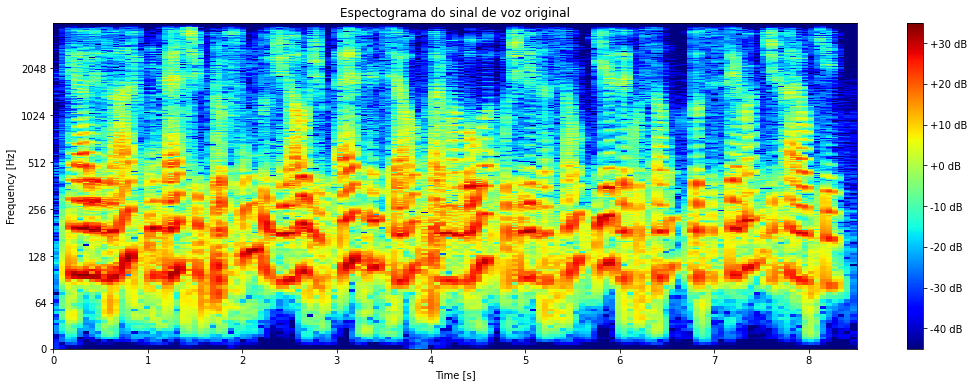

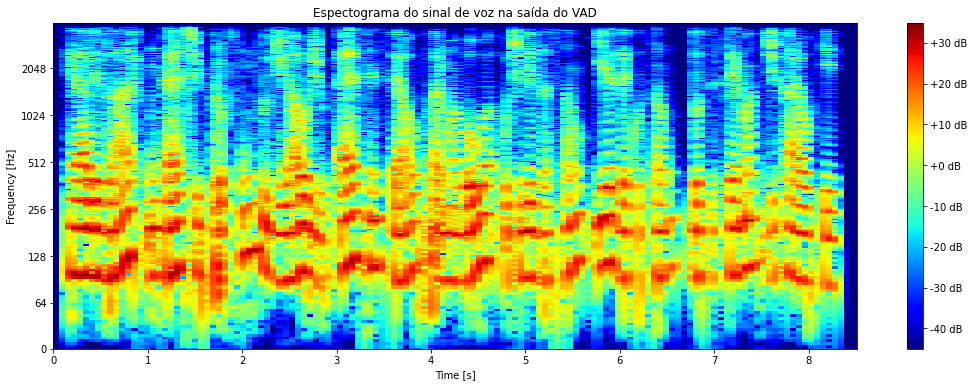

In [ ]:
audio_stft_s = np.abs(librosa.stft(audio_resample))
audio_stft_z = np.abs(librosa.stft(z))

plt.figure(figsize=(18,6))
specshow(librosa.amplitude_to_db(audio_stft_s), 
         y_axis='log', 
         x_axis='time',
         cmap='jet', 
         sr=fs)
plt.title('Espectograma do sinal de voz original')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(format='%+2.0f dB')

plt.figure(figsize=(18,6))
specshow(librosa.amplitude_to_db(audio_stft_z), 
         y_axis='log', 
         x_axis='time',
         cmap='jet', 
         sr=fs)
plt.title('Espectograma do sinal de voz na saída do VAD')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(format='%+2.0f dB')

### Parte 4: Identificando trechos (frames) de sinais de voz do tipo vozeados e não vozeados

#### Exemplo 1: Trecho de sinal vozeado (fonema /o/)

In [ ]:
ii_v = 140
Audio(data=audio_vad[ii_v,:], rate=fs) # Reproduzindo o trecho de sinal vozeado

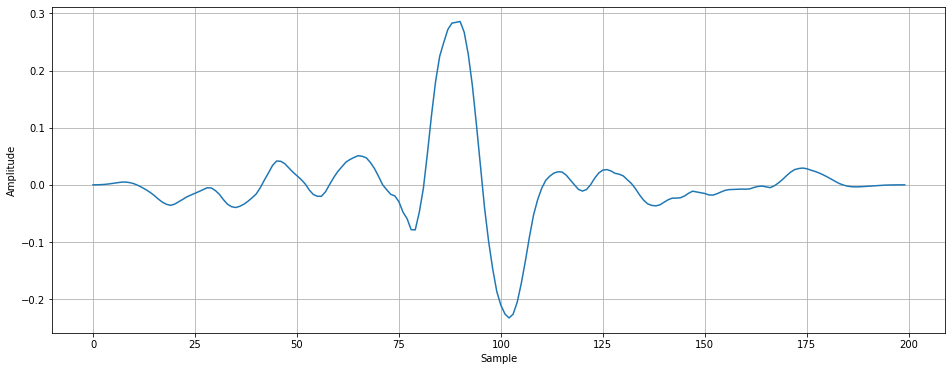

In [ ]:
plt.figure(figsize=(16,6))
plot(audio_vad[ii_v,:])
ylabel('Amplitude')
xlabel('Sample')
plt.grid(True)

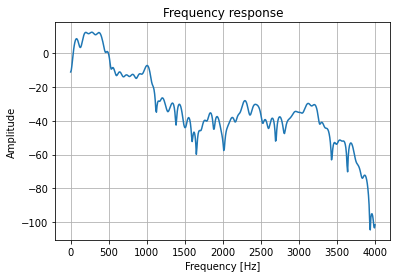

In [ ]:
mfreqz(audio_vad[ii_v,:],a=1,fs=8000)

#### Exemplo 2: Trecho de sinal não vozeado (fonema /t/)

In [ ]:
ii_nv = 113
Audio(data=audio_vad[ii_nv,:], rate=fs) # Reproduzindo o trecho de sinal não vozeado

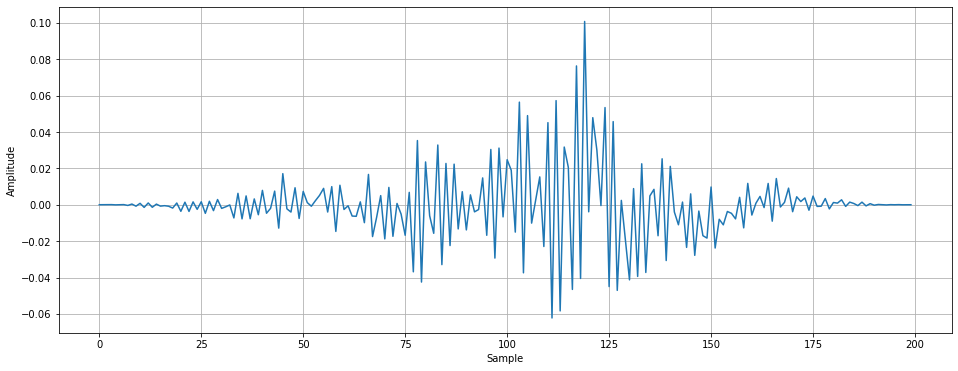

In [ ]:
ii_nv = 113
plt.figure(figsize=(16,6))
plot(audio_vad[ii_nv,:])
ylabel('Amplitude')
xlabel('Sample')
plt.grid(True)

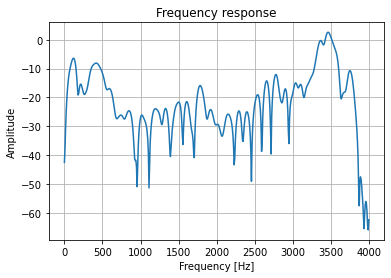

In [ ]:
mfreqz(audio_vad[ii_nv,:],a=1,fs=8000)

## Exercício 2
Qual a diferença entre as formas de onda obtidas para o sinal de voz vozeado e o sinal de voz não vozeado? <br> E qual a diferença nos espectros de amplitude?

Por meio das ilustrações das formas de onda foi possível observar que:
 
*   O sinal de voz vozeado é um sinal periódico, como já se esperava. O seu espectro de amplitude revela as formantes da fala vozeada.
*   O sinal de voz vozeado é um sinal aleatório (ruído). E o seu espectro de amplitude possui uma distribuição mais uniforme, o que está de acordo com o espectro de amplitude de ruído.

## Exercício 3
Utilizando o trecho do sinal de voz do tipo vozeado, obtenha o espectro de frequência do sinal vozeado e resposta em frequência do filtro obtido com a inversão do filtro LPC, para P = 4, P = 16, P = 32 e P = 64. O que acontece com a resposta em frequência deste filtro?

Para o trecho do sinal vozeado (ii=129)

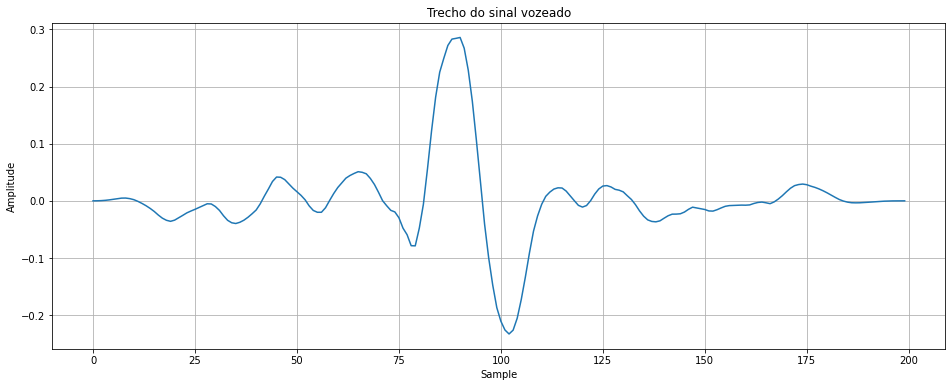

In [ ]:
plt.figure(figsize=(16,6))
plot(audio_vad[ii_v,:])
ylabel('Amplitude')
xlabel('Sample')
plt.title('Trecho do sinal vozeado')
plt.grid(True)

### P=4

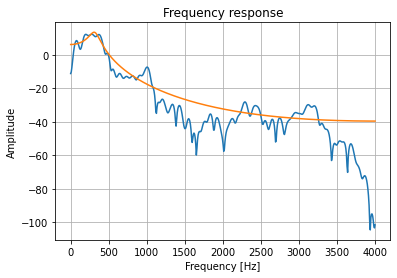

In [ ]:
N        = frame_size - 1
r_window = np.zeros([n_windows,N+1])
y_delay  = np.zeros([frame_size])
for ii in range(n_windows):
  for jj in range(N+1):
    if max_amp_frames[ii] > max_lim:
        y_delay         = np.concatenate((np.zeros([jj]),y_window[ii,0:frame_size-jj]), axis=None)
        r_window[ii,jj] = sum(y_delay*y_window[ii,:])

P         = 4 # P do LPC
lpc       = np.zeros([n_windows,P+1])
g_lpc     = np.zeros([n_windows])
for ii in range(n_windows):
  if max_amp_frames[ii] > max_lim:
    ld        = LevinsonDurbinRecursion(r_window[ii,0:P+2])
    lpc[ii,:] = ld.solve()
    g_lpc[ii] = sum(lpc[ii,:]*r_window[ii,0:P+1])**0.5

e_window       = np.zeros([n_windows,frame_size])
for ii in range(n_windows):
  if max_amp_frames[ii] > max_lim:
    b = lpc[ii,:]
    a = 1
    x = y_window[ii,:]
    e_window[ii,:] = signal.lfilter(b,a,x)

mfreqz(audio_vad[ii_v,:],a=1,fs=8000)
mfreqz(g_lpc[ii_v],lpc[ii_v,:],fs=8000)

### P=8

P = 8


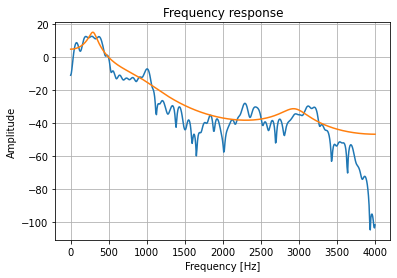

In [ ]:
P         = 8 # P do LPC
lpc       = np.zeros([n_windows,P+1])
g_lpc     = np.zeros([n_windows])
for ii in range(n_windows):
  if max_amp_frames[ii] > max_lim:
    ld        = LevinsonDurbinRecursion(r_window[ii,0:P+2])
    lpc[ii,:] = ld.solve()
    g_lpc[ii] = sum(lpc[ii,:]*r_window[ii,0:P+1])**0.5

e_window       = np.zeros([n_windows,frame_size])
for ii in range(n_windows):
  if max_amp_frames[ii] > max_lim:
    b = lpc[ii,:]
    a = 1
    x = y_window[ii,:]
    e_window[ii,:] = signal.lfilter(b,a,x)

print('P = '+str(P))
mfreqz(audio_vad[ii_v,:],a=1,fs=8000)
mfreqz(g_lpc[ii_v],lpc[ii_v,:],fs=8000)

### P=16

P = 16


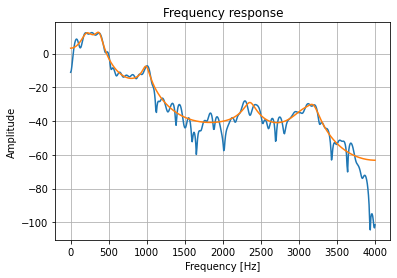

In [ ]:
P         = 16 # P do LPC
lpc       = np.zeros([n_windows,P+1])
g_lpc     = np.zeros([n_windows])
for ii in range(n_windows):
  if max_amp_frames[ii] > max_lim:
    ld        = LevinsonDurbinRecursion(r_window[ii,0:P+2])
    lpc[ii,:] = ld.solve()
    g_lpc[ii] = sum(lpc[ii,:]*r_window[ii,0:P+1])**0.5

e_window       = np.zeros([n_windows,frame_size])
for ii in range(n_windows):
  if max_amp_frames[ii] > max_lim:
    b = lpc[ii,:]
    a = 1
    x = y_window[ii,:]
    e_window[ii,:] = signal.lfilter(b,a,x)

print('P = '+str(P))
mfreqz(audio_vad[ii_v,:],a=1,fs=8000)
mfreqz(g_lpc[ii_v],lpc[ii_v,:],fs=8000)

### P=32

P = 32


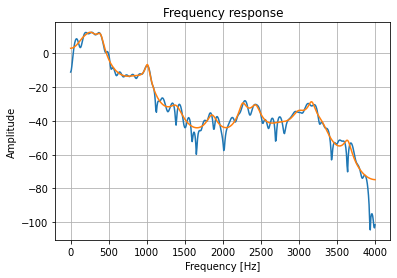

In [ ]:
N        = frame_size - 1
r_window = np.zeros([n_windows,N+1])
y_delay  = np.zeros([frame_size])
for ii in range(n_windows):
  for jj in range(N+1):
    if max_amp_frames[ii] > max_lim:
        y_delay         = np.concatenate((np.zeros([jj]),y_window[ii,0:frame_size-jj]), axis=None)
        r_window[ii,jj] = sum(y_delay*y_window[ii,:])

P         = 32 # P do LPC
lpc       = np.zeros([n_windows,P+1])
g_lpc     = np.zeros([n_windows])
for ii in range(n_windows):
  if max_amp_frames[ii] > max_lim:
    ld        = LevinsonDurbinRecursion(r_window[ii,0:P+2])
    lpc[ii,:] = ld.solve()
    g_lpc[ii] = sum(lpc[ii,:]*r_window[ii,0:P+1])**0.5

e_window       = np.zeros([n_windows,frame_size])
for ii in range(n_windows):
  if max_amp_frames[ii] > max_lim:
    b = lpc[ii,:]
    a = 1
    x = y_window[ii,:]
    e_window[ii,:] = signal.lfilter(b,a,x)

print('P = '+str(P))
mfreqz(audio_vad[ii_v,:],a=1,fs=8000)
mfreqz(g_lpc[ii_v],lpc[ii_v,:],fs=8000)

É possível notar que aumentando a ordem do filtro aumenta-se a precisão na representação da envoltória espectral do espectro de amplitude do trecho de sinal analisado, ou seja, aumenta-se a precisão do filtro.

## Exercício 4

Qual a diferença entre o sinal na entrada do LPC e na sua saída?

A diferença entre o sinal na entrada do LPC e na sua saída é o sinal de diferença e(n), chamado de resíduo ou erro de predição.


## Exercício 5

O que acontece com o sinal de saída do LPC (erro de predição) ao aumentarmos o valor de P?

Ao aumentarmos o valor de P consequentemente aumentamos a precisão do filtro LPC, logo, haverá uma diminuição no erro de predição.